# Fine Tune ViT

In [1]:
!nvidia-smi

Mon Feb 12 02:35:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T600 Lap...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P5     7W /  35W |      9MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Fine_Tune
~Kuggleの衛星画像写真を用いて天候の画像分類を行う~  
~[Satellite Image Classification](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)~  

分類が簡単すぎたので、Pretrinedモデルではおそらくクラスがなく推論が失敗する以下の鳥分類データセットを使う  
[BIRDS 525 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)  
`/workspace/data/brid_dataset/archive.zip`となるようにデータを配置し、解凍する  
```unzip archive.zip```

`import`は、用いるViTのアーキテクチャに合わせる

In [2]:
import requests
from PIL import Image
from tqdm import tqdm
import torch
import GPUtil
import os
from PIL import Image

#ViTアーキテクチャに合わせる
from transformers import ViTImageProcessor as ViTImageProcessor
from transformers import ViTForImageClassification as ViTForImageClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.cuda.empty_cache()
GPUtil.showUtilization()

cuda
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


## PreTrainedモデルの準備

In [3]:
# Simple ViT model
model_name = "google/vit-base-patch16-224"

#プロキシがある場合はproxy_dic={http: < yur're proxy >}の辞書形式で渡す．
#ViTImageProcessor.from_pretrained(model_name,proxy_dic=proxy_dic)
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

In [4]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


## データセットの読み込みと処理
データセットを用意する

データセットがクラス分けのみであればtrain,test validationに分割するコードがあるので適宜実行する.  
分割のパラメータは適宜調整する  
(defalt)  
Train Ratio: 0.8  
Validation Ratio: 0.1  
Test Ratio: 0.1  
`python3 Make_Dataset.py`


ディレクトリ配置例
```
.
├── Dockerfile
├── LICENSE
├── README.md
├── container_in.sh
├── data
│   ├── bird_dataset
│   │   ├── EfficientNetB0-525-(224 X 224)- 98.97.h5
│   │   ├── archive.zip
│   │   ├── birds.csv
│   │   ├── test
│   │   ├── train
│   │   └── valid
│   └── test_data
│       ├── Pembroke_Welsh_Corgi.jpg
│       ├── kiji.jpg
│       └── kingfisher.jpg
├── docker-compose.yml
├── run.sh
└── src
    ├── Fine_tune_ViT.ipynb
    ├── Make_Dataset.py
    ├── ViT_tut.ipynb
    ├── viT_Estimete_Fine_Tune.ipynb
    └── vit-weight
        ├── checkpoint-15500
        ├── checkpoint-16000
        ├── checkpoint-16500
        └── runs

```

In [5]:
from datasets import load_dataset

# load the custom dataset
ds = load_dataset("imagefolder", data_dir="/workspace/data/bird_dataset/")
#ds = load_dataset("csv",  data_files="/workspace/data/bird_dataset/birds.csv")

ds

Resolving data files:   0%|          | 0/84635 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2625 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2625 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 84635
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2625
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2625
    })
})

### ラベルの確認
データセットのtrain内のクラスが1つの場合、Noneと表示される．  
このときラベルが必要であるなら、明示する必要がある  
`load_dataset("imagefolder", data_dir="/workspace/data/Dataset", drop_labels=False)`

In [6]:
labels = ds["train"].features["label"]
print(labels)
print(labels.int2str(ds["train"][102]["label"]))
print(labels.int2str(ds["train"][202]["label"]))

ClassLabel(names=['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', '

### データの確認
読み込んでいる画像データとラベルを確認する

In [7]:
import random
import matplotlib.pyplot as plt

def show_image_grid(dataset, split, grid_size=(4,4)):
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]
    
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(ds["train"].features["label"].int2str(labels[i]))
    
    plt.show()

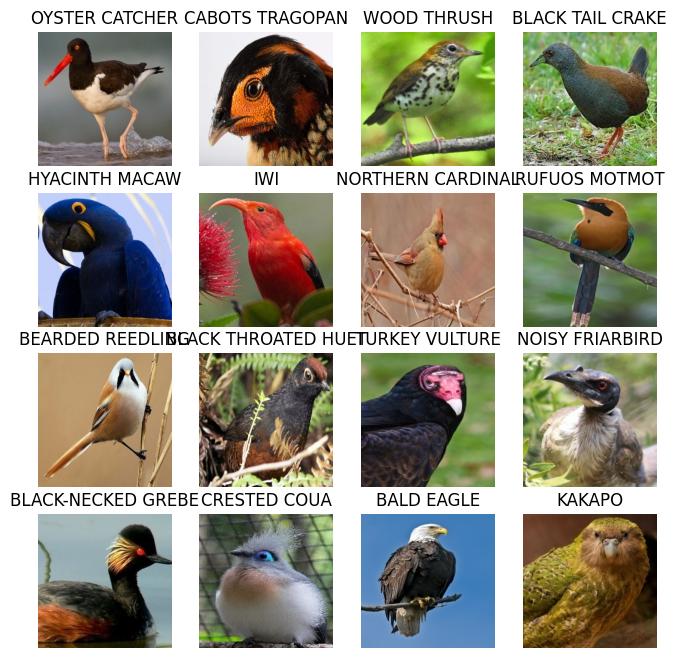

In [8]:
show_image_grid(ds, "test")

## 前処理
画像の読み込みができたので、すべてのRGB形式の画像をPytorchテンソルに変換する

In [9]:
def transform(examples):
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  inputs["labels"] = examples["label"]
  return inputs

dataset = ds.with_transform(transform)

#### テンソルの確認
torch.Size([3, 224,224])　ー＞　RGB 3チャンネル　

In [10]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  break

torch.Size([3, 224, 224])
0


#### ラベルを取得できるか確認

In [11]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN DIPPER',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE 

#### バッチを積み重ねて照合させるための関数
データセットからのバッチを受け取り、ピクセル値とラベルを含む辞書形式のテンソルを返す

In [12]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

## メトリックの定義
TrainerAPIが、`compute_metric`関数を用いるため用意する．  
AccuracyとF1の算出を行う  
evaluateを今回もいいているが、scikitlearnを用いてもよい

（eval_pred.predicions, axis=1）で各クラスにおける最大確率を算出し、argmax()でそのindexを求めている．  
また、正解ラベルを取り出し

In [13]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

## モデルの学習

#### 出力クラスの初期化

In [14]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([526]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([526, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 学習の準備

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-weight", # Fine tuneモデルの出力先
  per_device_train_batch_size=10, # バッチサイズ
  per_device_eval_batch_size=8,   # バッチサイズ
  evaluation_strategy="steps",    # ステップごとに評価
  num_train_epochs=2,             # epoch数
  #fp16=True,                      # 混合精度
  save_steps=500,                  # チェックポイントを保存頻度
  eval_steps=500,                  # モデルの評価を行う頻度
  logging_steps=500,               # 更新ステップごとにログ
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=3,             # ディスク上のチェックポイントの総量を制限
  remove_unused_columns=False,    # データセットから未使用の列を削除する
  push_to_hub=False,              # モデルをハブにプッシュしない
  report_to='tensorboard',        # メトリクスをTensorBoardに渡す
  load_best_model_at_end=True,    #6_full_eval (bool, optional, defaults to False) — Whether to use full float16 evaluation instead of 32-bit. This will be faster and save memory but can harm metric values. 学習の最後に最良のモデルをロードする
  use_cpu=False,                   # CPUの使用　Flase->GPU・TPUの使用
  #fp16_full_eval=True
)

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # 事前学習済みモデルの用意
    args=training_args,                 # 設定したArgumentsを渡す
    data_collator=collate_fn,           # ラベル照合用の関数を渡す
    compute_metrics=compute_metrics,    # 評価時に使うメトリック関数を渡す
    train_dataset=dataset["train"],     # 訓練データセット
    eval_dataset=dataset["validation"], # 評価データセット
    tokenizer=image_processor,          # トークナイザー
)

In [17]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 21% |


####　学習の開始

In [18]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
500,5.134500,3.646356,0.645333,0.591693
1000,2.649400,1.659642,0.862095,0.838723
1500,1.249600,0.773362,0.930667,0.921018
2000,0.683000,0.436778,0.946667,0.940026
2500,0.429100,0.274355,0.960000,0.955489
3000,0.334400,0.214172,0.964571,0.959356
3500,0.264100,0.181194,0.967619,0.964426
4000,0.253900,0.164727,0.965333,0.962324
4500,0.217500,0.136684,0.974095,0.971265
5000,0.206900,0.129869,0.973333,0.970499


TrainOutput(global_step=16928, training_loss=0.40241693954611996, metrics={'train_runtime': 18331.8646, 'train_samples_per_second': 9.234, 'train_steps_per_second': 0.923, 'total_flos': 1.3178672692061184e+19, 'train_loss': 0.40241693954611996, 'epoch': 2.0})

In [19]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 98% | 87% |


### テストデータで検証

In [20]:
output= trainer.predict(dataset["test"])

In [21]:
output.metrics

{'test_loss': 0.02646920271217823,
 'test_accuracy': 0.993904761904762,
 'test_f1': 0.993770081770082,
 'test_runtime': 97.5077,
 'test_samples_per_second': 26.921,
 'test_steps_per_second': 3.374}

### 混合行列
分類クラスが多すぎるとわかりにくいです

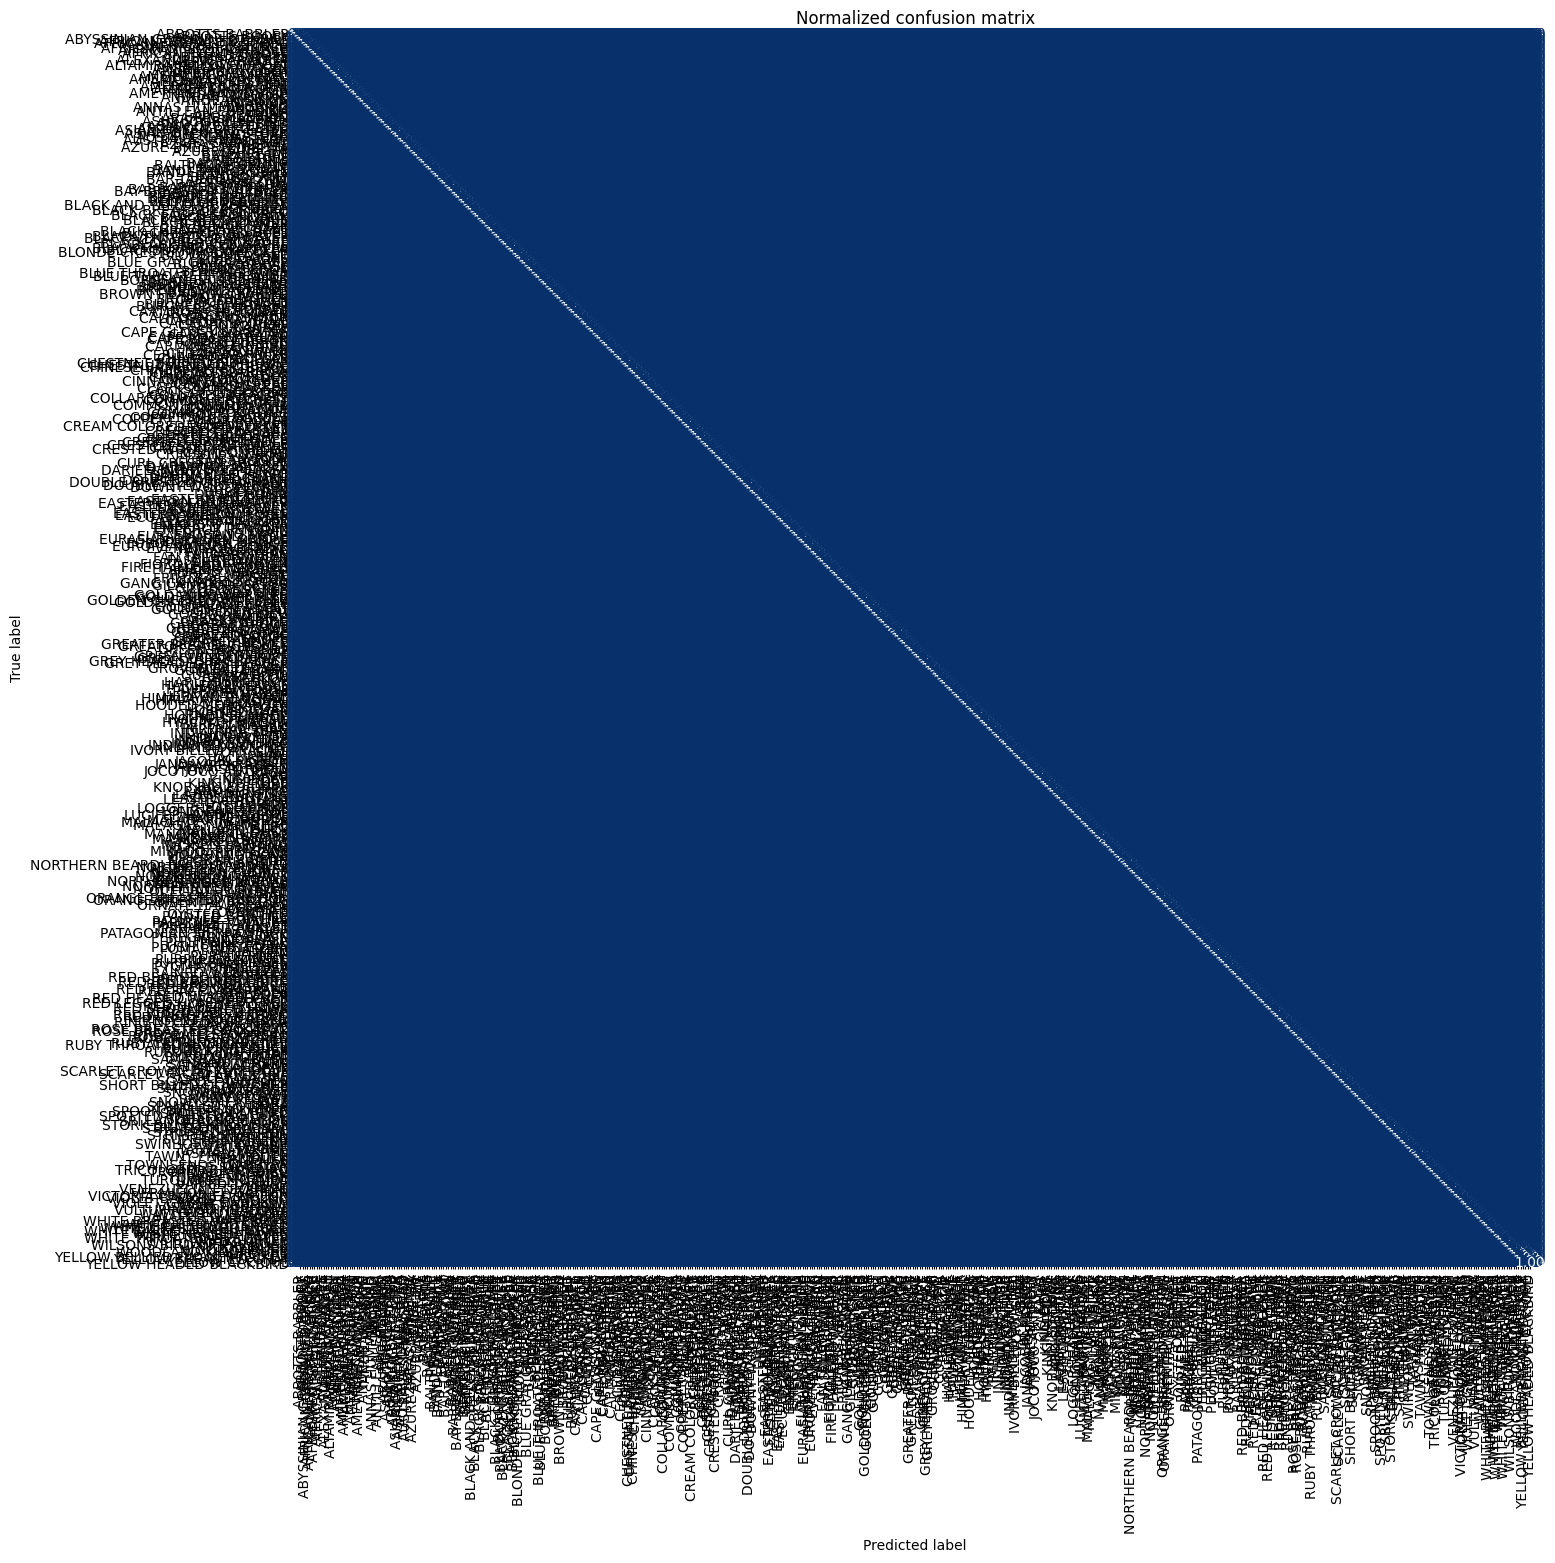

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(output.predictions, axis=1)
y_valid = np.array(ds["test"]["label"])
labels = ds["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(16,16))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    ax.set_xticklabels(labels, rotation=90) 
    ax.set_yticklabels(labels, rotation=0) 
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels[:-1])

In [23]:
trainer.evaluate(dataset["test"])

{'eval_loss': 0.02646920271217823,
 'eval_accuracy': 0.993904761904762,
 'eval_f1': 0.993770081770082,
 'eval_runtime': 96.2067,
 'eval_samples_per_second': 27.285,
 'eval_steps_per_second': 3.42,
 'epoch': 2.0}

## 推論

In [24]:
def get_prediction_probs(model, url_or_path, num_classes=3):
    img = Image.open(url_or_path)
    pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
    output = model(pixel_values)
    probs, indices = torch.topk(output.logits.softmax(dim=1), k=num_classes)
    id2label = model.config.id2label
    classes = [id2label[idx.item()] for idx in indices[0]]
    probs = probs.squeeze().tolist()
    results = dict(zip(classes, probs))
    return results

In [26]:
from PIL import Image
best_checkpoint = 16500
best_model = ViTForImageClassification.from_pretrained(f"/workspace/src/vit-weight/checkpoint-{best_checkpoint}").to(device)
get_prediction_probs(best_model, "/workspace/data/bird_dataset/test/PYGMY KINGFISHER/3.jpg")

{'PYGMY KINGFISHER': 0.9989274144172668,
 'MALACHITE KINGFISHER': 0.0003117609303444624,
 'RUFOUS KINGFISHER': 0.00014921906404197216}